In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.lines import Line2D  
from scipy.stats import norm  # You can use other distribution functions from scipy.stats
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from matplotlib.dates import DateFormatter, AutoDateLocator
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
import matplotlib.cm as cm


In [19]:
def transpose_single_insar_timeseries(df):
    # Get the fields starting with 'D2'
    fields = [col for col in df.columns if col.startswith('D2')]
    
    # Create a list of dataframes to concatenate
    dfs = []
    
    for f in fields:
        #print (f)
        # Create a new dataframe with selected columns
        cur_df = df[['CODE', 'CLUSTER_ID', 'Aspect', 'Slope', 'Sus_Ab', 'Sus_BC', f]].copy()
        
        # Rename the displacement column
        cur_df.rename(columns={f: 'displacement'}, inplace=True)
        
        # Extract the date from the column name
        cur_df['date'] = f.replace("D", "")
        
        # Append the current dataframe to the list
        dfs.append(cur_df)
    
    # Concatenate all dataframes in the list
    
    out_df = pd.concat(dfs, ignore_index=True)
    out_df['absDisplacement'] = out_df['displacement'].abs()
    
    return out_df


def calculate_incremental_displacement(df):
    # Ensure the dataframe is sorted by date
    df = df.sort_values(by='date').reset_index(drop=True)

    # Create a year column
    df['year'] = df['date'].dt.year

    # Group by code and year, then calculate incremental displacement for each group
    df['incremental_displacement'] = df.groupby(['CODE', 'year'])['displacement'].diff().fillna(0)
    #df['annual_cumulative_displacement'] = df.groupby(['CODE', 'year'])['absDisplacement'].cumsum()
    #df['incremental_displacement'] = df['incremental_displacement'].abs()

    return df

# Subtract the first displacement value of each year and calculate cumulative sum
def adjust_displacement(group):
    return (group - group.iloc[0]).cumsum()



In [55]:
# Function to filter trends and flag the points based on the rules for a specific CODE
def filter_trends_and_flag(df, code, dc):
    for year, group in df[df['CODE'] == code].groupby('year'):
        group = group.reset_index()
        trends = []
        start_idx = 0

        while start_idx < len(group):
            end_idx = start_idx + 1

            # Define a trend by continuous displacement values
            while end_idx < len(group) and group.loc[end_idx, dc] > group.loc[end_idx - 1, dc]:
                end_idx += 1

            trend_df = group.iloc[start_idx:end_idx]

            # Check if the trend lasts at least two weeks and has at least two points
            if (end_idx - start_idx >= 3) and ((trend_df['date'].max() - trend_df['date'].min()).days >= 10):
                trends.append(trend_df)

            start_idx = end_idx

        if trends:
            filtered_df = pd.concat(trends)
            # Ensure displacement does not go down
            valid_trend_df = filtered_df[filtered_df[dc] >= filtered_df[dc].cummax()]

            # Update the flag column in the original dataframe
            valid_indices = valid_trend_df['index'].values
            df.loc[df.index.isin(valid_indices), 'is_valid_trend'] = True

    return df

# Function to plot raw and filtered time series for a given CODE
def plot_time_series(df, code, dc):
    raw_df = df[df['CODE'] == code]
    filtered_df = raw_df[raw_df['is_valid_trend']]
    
    plt.figure(figsize=(12, 6))
    

    ""
    
    # Plot filtered time series
    if not filtered_df.empty:
        
        plt.scatter(filtered_df['date'], filtered_df[dc], color = 'orange', label='Filtered Time Series')
    # Plot raw time series
    plt.plot(raw_df['date'], raw_df[dc], label='Raw Time Series')
    plt.scatter(raw_df['date'], raw_df[dc], marker='.')
    plt.xlabel('Date')
    plt.ylabel(dc.replace('_', ' ').title())
    plt.title(f'Time Series for CODE {code}')
    plt.legend()
    plt.show()


# Function to fit LOESS and return a dataframe with smoothed points for each CODE/year combination
def fit_loess_w_plot(df, code, displacement_column, smoothed_df, raw_df, plot, residual_threshold=0.1):
    df = df.sort_values(by=['CODE', 'date']).reset_index(drop=True)    
    for year, group in df[df['CODE'] == code].groupby('year'):
        #print (year)
        group = group.reset_index(drop=True)
        dates = group['date']
        
        loess_fit = sm.nonparametric.lowess(group[displacement_column], group.index, frac=0.75)  # Use group index as dates

        # Calculate residuals
        residuals = group[displacement_column] - loess_fit[:, 1]
        # Filter points based on residuals
        filtered_group = group[np.abs(residuals) < residual_threshold]
        smoothed_group = pd.DataFrame(loess_fit, columns=['index', displacement_column])  # Use group index as dates
        smoothed_group['date'] = dates
        smoothed_group['year'] = year
        #print (year)
        smoothed_group['CODE'] = code
        smoothed_group['smoothed_displacement'] = smoothed_group[displacement_column]
        smoothed_df = pd.concat([smoothed_df, smoothed_group], ignore_index=True)
        #print(smoothed_group)
        if plot==True:
            fig, ax = plt.subplots()
            plt.scatter(group['date'], group[displacement_column], color='black', marker='o',  label='Displacement (mm)')
            ax.plot(group['date'], group[displacement_column], color='orange',  linestyle = "--", label='Smoothed Displacement (cumulative annual)', linewidth=3)
            ax.plot(smoothed_group['date'], smoothed_group[displacement_column], color='blue', linestyle = "--", label='Smoothed  Displacement (cumulative annual w/ LOESS)', linewidth=2)
            raw_df_cur = raw_df[(raw_df['CODE'] == code) & (raw_df['year'] == year)]
            ax.plot(raw_df_cur['date'], raw_df_cur[displacement_column], color='grey', linestyle = "--", label='Raw Data (Cumulative)', linewidth=0.5, marker='.')
            #ax.plot(raw_df_cur['date'], raw_df_cur['incremental_displacement'], color='black', linestyle = "--", label='Raw Data (Incremental)', linewidth=0.5)
            plt.xlabel('Date')
            plt.ylabel(displacement_column.replace('_', ' ').title())
            plt.title(f'LOESS Fit for CODE {code} in Year {year}')
            plt.legend()
            #plt.show()
    
    return smoothed_df 

In [75]:
in_df = pd.read_csv('FSJ_Clip_WCSB_SNT_T166_A_CA2745B1S_clustered.csv')
df =transpose_single_insar_timeseries(in_df)

df['date'] = pd.to_datetime(df['date']) 
df['year'] = df['date'].dt.year

# Sort the dataframe
df = df.sort_values(by=['CODE', 'date'])

# Initialize the flag column with False if not already present
if 'is_valid_trend' not in df.columns:
    df['is_valid_trend'] = False

df = calculate_incremental_displacement(df)

code_list = ['OP37OQY', 'ONOLUC7', 'ONKFT3U']

df['annual_cumulative_displacement'] = df.groupby(['CODE','year'])['absDisplacement'].transform(lambda x: x - x.iloc[0])
df['annual_cumulative_displacement'] = df.groupby(['CODE','year'])['annual_cumulative_displacement'].transform(lambda x: x - x.iloc[0])

displacement_column = 'annual_cumulative_displacement'
df_copy = df.copy()
df_copy.to_csv('transposed_FSJ_Clip_WCSB_SNT_T166_A_CA2745B1S_clustered.csv', index=False)
df = df[df['CLUSTER_ID'] == 16665]
# Get the unique codes
unique_codes = df['CODE'].unique()
# Loop through each unique code
#unique_codes = ['OP37OQY', 'ONOLUC7', 'ONKFT3U']
for code in unique_codes:
    #print (code)
    filter_trends_and_flag(df, code, displacement_column)
    #plot_time_series(df, code, displacement_column)
df =df[df['is_valid_trend'] == True]
#df['annual_cumulative_displacement'] = df.groupby(['CODE','year'])['absDisplacement'].transform(lambda x: x - x.iloc[0])
df['annual_cumulative_displacement'] = df.groupby(['CODE','year'])['annual_cumulative_displacement'].transform(lambda x: x - x.iloc[0]) 
df = df.sort_values(by=['CODE', 'date']).reset_index(drop=True)




In [ ]:
smoothed_df = pd.DataFrame(columns=['CODE', 'date', 'smoothed_displacement'])  # Blank dataframe
#only run for specific codes
code_list = ['OP37OQY', 'ONOLUC7', 'ONKFT3U']
for code in code_list:
    smoothed_df = fit_loess_w_plot(df, code, 'annual_cumulative_displacement', smoothed_df, df_copy, plot=True)

In [6]:
df.to_csv('filtered_insar.csv', index=False) 
#smoothed_df.to_csv('smoothed_insar.csv', index=False)   

In [82]:
def caclulate_velocity(df, displacement_column, time_column='date'):

    velocities = []
    for code, subset in df.groupby('CODE'):
        for year, year_subset in subset.groupby(subset[time_column].dt.year):
            year_subset = year_subset.sort_values(by=['CODE', 'date']).reset_index(drop=True)
            # Predict the displacement values using the LOESS model
            min_date, max_date = year_subset[time_column].min(), year_subset[time_column].max()
            min_date_ordinal, max_date_ordinal = min_date.toordinal(), max_date.toordinal()

            min_displacement = year_subset[displacement_column].iloc[0]
            max_displacement = year_subset[displacement_column].iloc[-1]
            # Calculate velocity based on the predicted values
            time_span_years = (max_date - min_date).days / 365.25
            velocity = (max_displacement - min_displacement) / time_span_years
            
            # Create DataFrame row for the velocity
            temp_df = pd.DataFrame({
                'date': pd.Timestamp(min_date),
                'CODE': code,
                'year': year,
                'annualized_velocity': velocity,
                displacement_column:displacement_column
                
            }, index=[0])
            velocities.append(temp_df)
    
    # Combine all velocity DataFrames into a single DataFrame
    velocity_df = pd.concat(velocities, ignore_index=True)
    return velocity_df


def histograms_by_year(df, displacement_column, date_field):
    # Ensure the date is in datetime format
    df[date_field] = pd.to_datetime(df[date_field])
    df[displacement_column] = df[displacement_column].abs()
    # Extract unique years
    unique_years = df['date'].dt.year.unique()
    
    # Create a separate plot for each unique year
    for year in unique_years:
        # Filter data for the specific year
        subset = df[df[date_field].dt.year == year].copy()  # Ensure we're working on a copy to avoid SettingWithCopyWarning
        
        # Convert displacement_column to numeric if it's not already
        subset[displacement_column] = pd.to_numeric(subset[displacement_column], errors='coerce')
        
        # Drop NaN values in displacement_column
        subset = subset.dropna(subset=[displacement_column])
        
        # Create a figure-level distribution plot
        sns.displot(data=subset, x=displacement_column, kde=True)
        
        # Calculate additional statistics
        percentile_list = [25, 75]
        percentiles = np.percentile(subset[displacement_column], percentile_list)
        iqr = np.percentile(subset[displacement_column], 75) - np.percentile(subset[displacement_column], 25)
        kurt = subset[displacement_column].kurtosis()
        
        # Define a colormap
        cmap = cm.get_cmap('viridis', len(percentiles) + 2)  # Adding 2 for IQR and kurtosis
        
        # Add percentile lines with different colors
        for i, percentile in enumerate(percentiles):
            print (percentile)
            plt.axvline(x=percentile, color=cmap(i / (len(percentiles) - 1)), linestyle='--', label=f'{percentile_list[i]}th Percentile')
        
        # Add lines for IQR and kurtosis
        mean_displacement = subset[displacement_column].mean()
        plt.axvline(x=mean_displacement, color='black', linestyle='--', label='Mean')
        #plt.axvline(x=np.percentile(subset[displacement_column], 25) - 1.5 * iqr, color=cmap(len(percentiles) / (len(percentiles) + 1)), linestyle='--', label='Lower Bound (Q1 - 1.5*IQR)')
        #plt.axvline(x=np.percentile(subset[displacement_column], 75) + 1.5 * iqr, color=cmap((len(percentiles) + 1) / (len(percentiles) + 1)), linestyle='--', label='Upper Bound (Q3 + 1.5*IQR)')
        #plt.axvline(x=subset[displacement_column].mean() + kurt, color='red', linestyle='--', label=f'Kurtosis ({kurt:.2f})')
        
        plt.title(f'Distribution of {displacement_column} for Year {year}')
        plt.xlabel(displacement_column)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()


20.750180405528845
64.17239836979167


C:\Users\rcarter\AppData\Local\Temp\ipykernel_17600\2663926876.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(percentiles) + 2)  # Adding 2 for IQR and kurtosis


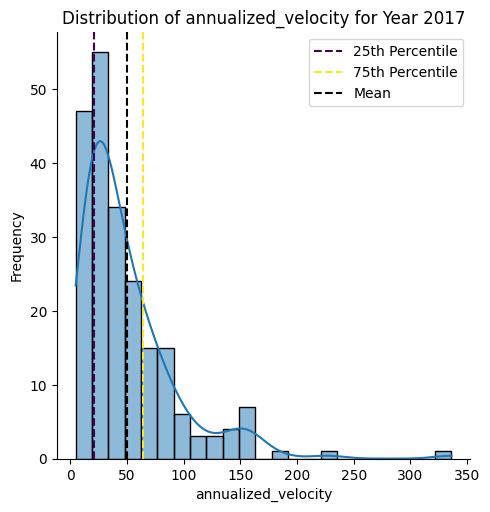

36.52499904882812
65.0601615765625


C:\Users\rcarter\AppData\Local\Temp\ipykernel_17600\2663926876.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(percentiles) + 2)  # Adding 2 for IQR and kurtosis


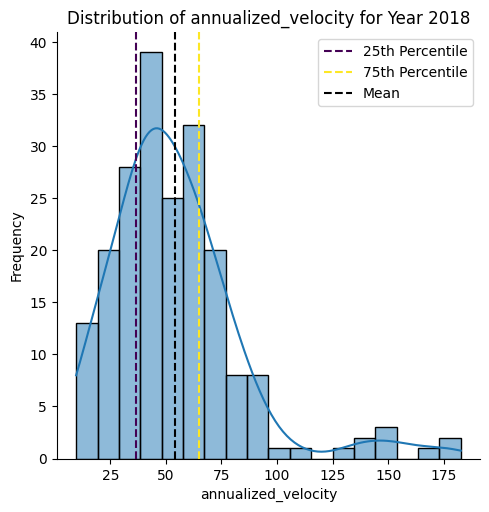

17.924302850000007
52.75833434791666


C:\Users\rcarter\AppData\Local\Temp\ipykernel_17600\2663926876.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(percentiles) + 2)  # Adding 2 for IQR and kurtosis


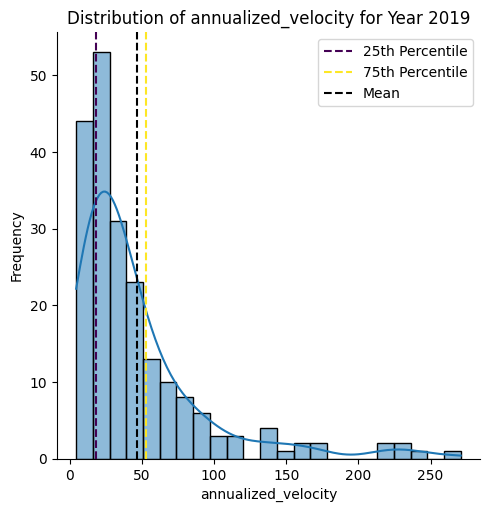

50.602333096875014
138.1102251148437


C:\Users\rcarter\AppData\Local\Temp\ipykernel_17600\2663926876.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(percentiles) + 2)  # Adding 2 for IQR and kurtosis


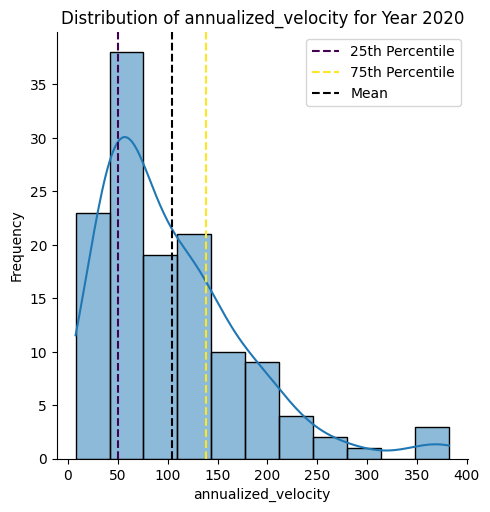

In [83]:
vdf = caclulate_velocity(df, 'annual_cumulative_displacement', time_column='date')
histograms_by_year(vdf, 'annualized_velocity', 'date')